#### Imports and settings

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import datetime
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import markovify as mk
from wordcloud import WordCloud, STOPWORDS

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import Constant

# Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score
from imblearn.metrics import specificity_score, sensitivity_score

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
tf.logging.set_verbosity(tf.logging.ERROR)

%matplotlib inline
%reload_ext jupyternotify

print('Intel-optimized TensorFlow is enabled:', tf.pywrap_tensorflow.IsMklEnabled())

Using TensorFlow backend.


<IPython.core.display.Javascript object>

Intel-optimized TensorFlow is enabled: True


In [21]:
time_flag = 0

# tap first time to start, tap second time to stop
def tap_timer(time_marker, start):
    now = time.time()
    elapsed_seconds = round(now - time_marker)
    time_marker = now
    if not start:
        print('\nOperation took %s [hh:mm:ss]' % datetime.timedelta(seconds=elapsed_seconds))
    return time_marker

#### Customize IDE (currently raw)

In [3]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams["figure.figsize"] = [10,5]

#### Load datasets and pretrained models

In [4]:
INPUT_PATH = '../input/'
SUBMISSION_PATH = '../submission/'
MODEL_PATH = '../model/'
PRETRAINED_PATH = '../pretrained-models/'

train = pd.read_csv(f'{INPUT_PATH}train.csv')
test = pd.read_csv(f'{INPUT_PATH}test.csv')
test_labels = pd.read_csv(f'{INPUT_PATH}test_labels.csv')

### EDA (Exploratory data analysis)

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train * 100 / (n_train + n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test  *100 / (n_train + n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [9]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

In [10]:
comments_labels_train = train_extended.iloc[:,2:]
comments_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (comments_labels_sums == 0)
n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples
print("Clean: ", n_clean_samples, "(", round(n_clean_samples * 100 / len(train_extended)), "% )")
print("Toxic: ", n_toxic_samples, "(", round(n_toxic_samples * 100 / len(train_extended)), "% )")

Clean:  143346 ( 90.0 % )
Toxic:  16225 ( 10.0 % )


###### <font color="LIGHTSALMON">The large majority of train dataset are comments labelled as clean</font>

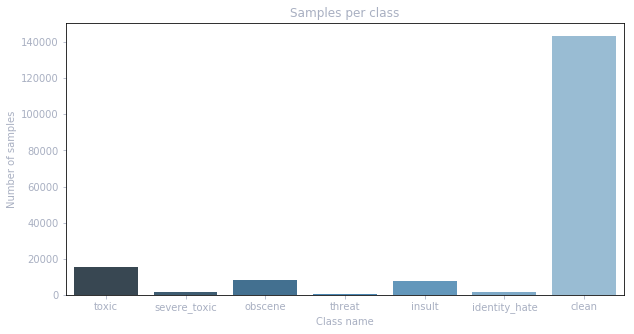

In [11]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

In [12]:
imbalance_ratios_class_names = {}
imbalance_ratios_class_nums = {}
for label in range(len(summed_labels_extended_train)):
    ratio_label = n_clean_samples / summed_labels_extended_train.get(label)
    imbalance_ratios_class_nums[label] = round(ratio_label, 2)
    imbalance_ratios_class_names[summed_labels_extended_train.index[label]] = round(ratio_label, 2)

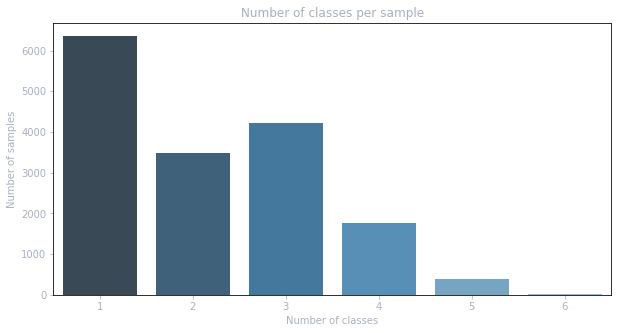

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [13]:
# without '0 classes' (clean comments)
multiple_classes_occurance = comments_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()
print(multiple_classes_occurance)

In [14]:
print("Single-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="LIGHTSALMON">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [15]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class), 1]

In [16]:
toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n>", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

> You are a piece of Shiit 

You are a pissant little creatin, who has no purpose in life. You graduated from a thirdclass college, but that's better than your prosti mom who's uneducated. You can't earn a thousandth of what Sweet Briar Alums earn. I saw your face, you are sooo ugly! You could never get into or pass at Sweet Briar with your monkey's brain!

 --- 

Severe toxic:

> Fuck off! 

Fuck off!

 --- 

Obscene:

> RE: 

Punk ass snitch, get the cock.

 --- 

Threat:

> burn in hell motherfucker

 --- 

Insult:

> "  WILL MY MOTHERFUCKING SAFETY BE GUARANTEED???? I FUCKING HOPE SO!!! I'M BRINGING MY OWN FUCKIN' WEAPONS!! PAY ME WHEN I GET BACK MOTHERFUCKERS!!!  OH YEAH I'VE GOT A JOKE...A FAMILY (HUSBAND, WIFE, SON, DAUGHTER, DOG) WALKS INTO AN AGENT'S OFFICE AND TELLS HIM THAT THEY'VE GOT A GREAT VAUDEVILLE ROUTINE...HE SAYS ""WE DON'T HIRE KIDDY ACTS"" AND THEY SAY ""BUT WE'RE REALLY GOOD!"" AND SO THE AGENT SAYS ""FINE, LET ME SEE WHAT YOU'VE GOT, BUT IF YOU SUCK I'M 

#### Wordclouds

In [23]:
time_flag = tap_timer(time_flag, start=True)

stopwords=set(STOPWORDS)

wordcloud_toxic = WordCloud(max_words=1000, stopwords=stopwords, colormap="Reds")
wordcloud_toxic.generate(" ".join(toxic_samples.comment_text.values))

wordcloud_clean = WordCloud(max_words=1000, stopwords=stopwords, colormap="Greens")
wordcloud_clean.generate(" ".join(clean_samples.comment_text.values))

time_flag = tap_timer(time_flag, start=False)

Operation took 0:00:54 [hh:mm:ss]


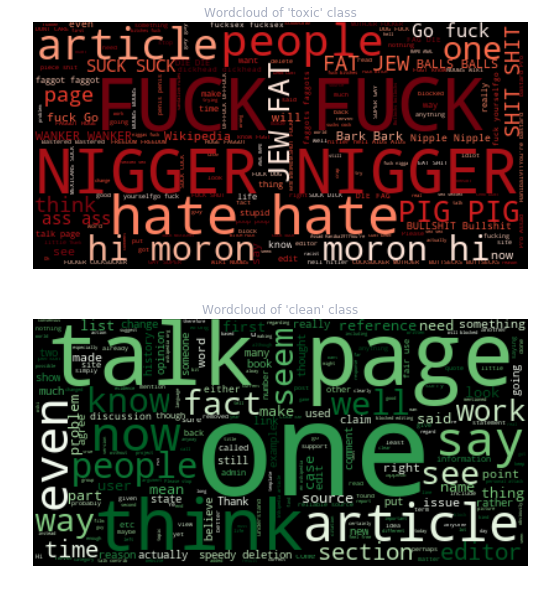

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.title("Wordcloud of \'toxic\' class")
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")

plt.subplot(212)
plt.axis("off")
plt.title("Wordcloud of \'clean\' class")
plt.imshow(wordcloud_clean, interpolation='bilinear')

plt.show()

#### Spam significance 

In [25]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = train_extended['n_unique_words'] * 100 / train_extended['n_words']

###### <font color="LIGHTSALMON">Spam ratio (coefficient) =  unique words in comment / number of words in comment</font>

In [26]:
spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]
print('For spam coefficient equal 10%:\n')
print('Clean spammers: ', n_clean_spammers, "(", round(n_clean_spammers * 100 / n_spammers), "% )")
print('Toxic spammers: ', n_toxic_spammers, "(", round(n_toxic_spammers * 100 / n_spammers), "% )")
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers), 
      'times more toxic spammers than clean ones!')

For spam coefficient equal 10%:

Clean spammers:  67 ( 19 % )
Toxic spammers:  292 ( 81 % )

There are 4.36 times more toxic spammers than clean ones!


In [27]:
spam_ratio_values = np.arange(0, 41, 1)
n_clean_spammers_values = []
n_toxic_spammers_values = []
for spam_ratio in spam_ratio_values:
    curr_spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
    curr_clean_spammers = curr_spammers[curr_spammers['clean'] == True]
    curr_toxic_spammers = curr_spammers[curr_spammers['clean'] == False]
    n_clean_spammers_values.append(curr_clean_spammers.shape[0])
    n_toxic_spammers_values.append(curr_toxic_spammers.shape[0])

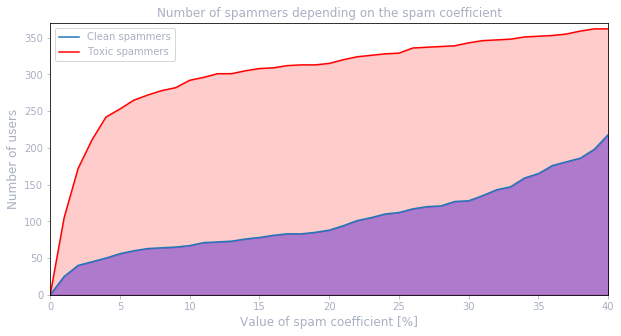

In [28]:
plt.title("Number of spammers depending on the spam coefficient", fontsize=12)

plt.plot(spam_ratio_values, n_clean_spammers_values)
plt.fill_between(spam_ratio_values, n_clean_spammers_values, 0, color='blue', alpha=0.4)  
plt.plot(spam_ratio_values, n_toxic_spammers_values, 'r')
plt.fill_between(spam_ratio_values, n_toxic_spammers_values, 0, color='red', alpha=0.2) 

plt.legend(['Clean spammers', 'Toxic spammers'])
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Value of spam coefficient [%]', fontsize=12)
plt.xlim(0, 40)
plt.ylim(0, 370)
plt.show()

In [29]:
spam_min_index = min(n_clean_spammers, n_toxic_spammers) - 1
print("Sample clean spam:\n\n>", clean_spammers.iloc[randint(0, spam_min_index)].comment_text)
print("\n --- \n\nSample toxic spam:\n\n>", toxic_spammers.iloc[randint(0, spam_min_index)].comment_text)

Sample clean spam:

> USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 
== USE THE RIGHT TEMPLATE n00b! ==

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 
== USE THE RIGHT TEMPLATE n00b! ==

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 
== USE THE RIGHT TEMPLATE n00b! ==

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b! 
== USE THE RIGHT TEMPLATE n00b! ==

 USE THE RIGHT TEMPLATE n00b! 

 USE THE RIGHT TEMPLATE n00b!

 --- 

Sample toxic spam:

> Hanibal911You're a bastard Pro-Assad. The rebels Aleppo Central Prison have been completely. Assad's like you're a bastard. Many men like to have sex with your mother, mother-Assad.You're a genital fit. Many men will serve your mother every day, and every day it eats genital. But you and your bastard Assad and parents. No Gvhy can not eat. Of course I understan

In [30]:
# Prepare as additional feature in training process
word_uniqueness_train = train_extended['unique_words_per']

##### Create synthetic training data using a Markov chain generator

In [31]:
# Split comments and labels
classes_names = train.columns.values[2:]
labels_train = train[classes_names].values
comments_train = train["comment_text"]

In [32]:
# One-hot vectors for each class
targets = np.array(np.arange(6)).reshape(-1)
one_hot_targets = np.eye(len(classes_names))[targets]
one_hot_targets_assigned = {}
for label in range(len(classes_names)):
    one_hot_targets_assigned[classes_names[label]] = one_hot_targets[label]

In [33]:
# Define analyzed set of classes and acceptable imbalance
include_clean_class = False
acceptable_imbalance_factor = .2

if include_clean_class:
    analyzed_classes = summed_labels_extended_train
else:
    analyzed_classes = summed_labels_extended_train[0:6]

In [34]:
max_n_samples = max(analyzed_classes)
n_samples_deficiency_factor = max_n_samples * acceptable_imbalance_factor

def get_deficient_classes(labels):
    deficient_classes = []
    for label in labels:
        n_samples_in_class = train[train[label] == True].shape[0]
        if (n_samples_in_class < n_samples_deficiency_factor): 
            deficient_classes.append(label)
    print('Qualified classes: %s' % deficient_classes)
    print('---')
    return deficient_classes

def get_params_for_markov_generator(labels):
    markov_params = {}
    for label in labels:
        label_params = {}
        imbalance_ratios_class_names
        label_comments = train[train[label] == True]['comment_text'].reset_index(drop=True)
        label_comments_bundle = label_comments.tolist()
        label_median_n_chars = int(label_comments.str.len().median())
        label_params['median_n_chars'] = label_median_n_chars
        print('Training Markov chain for class \'%s\'...' % label)
        label_params['markov_chain'] = mk.Text(label_comments_bundle)
        markov_params[label] = label_params
    print('---')
    return markov_params

def generate_synthetic_comments(params_for_markov_generator):
    synthetic_comments = {}
    for label in params_for_markov_generator:
        label_synthetic_comments = []
        label_model = params_for_markov_generator[label]['markov_chain']
        label_comment_length = params_for_markov_generator[label]['median_n_chars']
        label_n_comments = (max_n_samples * acceptable_imbalance_factor) - summed_labels_extended_train[label]
        print('Genereting %d synthetic comments of max. lenght %d for class \'%s\'...' % 
              (label_n_comments, label_comment_length, label))
        for i in range(int(label_n_comments)):
            label_synthetic_comments.append(label_model.make_short_sentence(label_comment_length))
        synthetic_comments[label] = label_synthetic_comments
    return synthetic_comments

def add_synthetic_comments_to_train(synthetic_comments):
    comments_train_list = comments_train.tolist()
    added_comments_sum = 0
    for label in synthetic_comments:
        comments_train_list = comments_train_list + synthetic_comments[label]
        added_comments_sum = added_comments_sum + len(synthetic_comments[label])
    # Transform back to Pandas object
    extended_comments_train = pd.Series(comments_train_list, name='comment_text')
    print('Data consistent after merging :', 
          validate_original_and_extended_sets(comments_train, extended_comments_train, added_comments_sum))
    return extended_comments_train
    
def validate_original_and_extended_sets(original_set, extended_set, added_comments_sum):
    old_n_samples = original_set.shape[0]
    shape_validation = old_n_samples + added_comments_sum == extended_set.shape[0]
    type_validation = type(original_set) == type(extended_set)
    random_index = randint(0, old_n_samples)
    random_comment_new_set = extended_set[random_index]
    random_comment_old_set = original_set[random_index]
    content_validation = random_comment_new_set == random_comment_old_set
    return shape_validation and type_validation and content_validation
    
def add_labels_of_synthetic_comments_to_train(synthetic_comments):
    list_label_matrices = []
    added_vectors_sum = 0
    # Collect all matrices into list
    for label in synthetic_comments:
        label_matrix = create_multipled_matrix(label)
        list_label_matrices.append(label_matrix)
        added_vectors_sum = added_vectors_sum + len(label_matrix)
    stacked_matrix_labels = concatenate_matrices(list_label_matrices)
    extended_labels_train = np.append(labels_train, stacked_matrix_labels, axis=0)
    print('Labels consistent after merging :', 
          validate_original_and_extended_labels(labels_train, extended_labels_train, added_vectors_sum))
    return extended_labels_train
        
def create_multipled_matrix(label):
    label_matrix = []
    for comment in range(len(synthetic_comments[label])):
        label_matrix.append(one_hot_targets_assigned[label])
    label_n_synthetic_comments = len(synthetic_comments[label])
    label_n_new_labels = len(label_matrix)
    assert label_n_synthetic_comments == label_n_new_labels
    return label_matrix

def concatenate_matrices(list_label_matrices):
    assert len(list_label_matrices) > 0
    stacked_matrix_labels = list_label_matrices[0]
    if (len(list_label_matrices) > 1):
        for i in np.arange(1, (len(list_label_matrices))):
            stacked_matrix_labels = np.concatenate((stacked_matrix_labels, list_label_matrices[i]))
    return stacked_matrix_labels
    
def validate_original_and_extended_labels(original_labels, extended_labels, added_vectors_sum):
    old_n_vectors = len(original_labels)
    length_validation = old_n_vectors + added_vectors_sum == len(extended_labels)
    random_index = randint(0, old_n_vectors)
    random_vector_new_labels = extended_labels[random_index]
    random_vector_old_labels = original_labels[random_index]
    content_validation = random_vector_new_labels == random_vector_old_labels
    if False in content_validation:
        content_validation_final = False
    else:
        content_validation_final = True
    return length_validation and content_validation_final

In [45]:
time_flag = tap_timer(time_flag, start=True)

deficient_classes = get_deficient_classes(classes_names)
params_for_markov_generator = get_params_for_markov_generator(deficient_classes)
synthetic_comments = generate_synthetic_comments(params_for_markov_generator)

time_flag = tap_timer(time_flag, start=False)

Qualified classes: ['severe_toxic', 'threat', 'identity_hate']
---
Training Markov chain for class 'severe_toxic'...
Training Markov chain for class 'threat'...
Training Markov chain for class 'identity_hate'...
---
Genereting 1463 synthetic comments of max. lenght 94 for class 'severe_toxic'...
Genereting 2580 synthetic comments of max. lenght 121 for class 'threat'...
Genereting 1653 synthetic comments of max. lenght 114 for class 'identity_hate'...
Operation took 0:00:18 [hh:mm:ss]


In [36]:
for label in deficient_classes:
    print('Sample synthetic comment of \'%s\' class\n' % label)
    print('> %s \n' % synthetic_comments[label][randint(0, len(synthetic_comments[label]))])

Sample synthetic comment of 'severe_toxic' class

> Message for Angie Yo need to get a warning for doing nothing? 

Sample synthetic comment of 'threat' class

> Hope you get raped. 

Sample synthetic comment of 'identity_hate' class

> Atheists tend to be Taught a Big Fat Faggot Pinko Commie Asshole 



In [37]:
extended_comments_train = add_synthetic_comments_to_train(synthetic_comments)
extended_labels_train = add_labels_of_synthetic_comments_to_train(synthetic_comments)

Data consistent after merging : True
Labels consistent after merging : True


In [38]:
# Check for nulls in generated comments
null_indexes = extended_comments_train[extended_comments_train.isnull()].index.tolist()
print('Found %d invalid comment(s)' % len(null_indexes))
if len(null_indexes) > 0:
    n_deletions = 0
    for index in null_indexes:
        extended_comments_train = extended_comments_train.drop(index - n_deletions).reset_index(drop=True)
        n_deletions += 1
    extended_labels_train = np.delete(extended_labels_train, null_indexes, axis=0)
    print('Incorrect data on following indexes was deleted: \n%s' % null_indexes)
print('---')
    
# final validation    
overall_consistency = extended_comments_train.shape[0] == len(extended_labels_train)
print('Labels and comments consistent: %s ' % overall_consistency)

Found 0 invalid comment(s)
---
Labels and comments consistent: True 


##### Plot differences in state of training dataset after oversampling

In [39]:
oversampled_summed_label = pd.DataFrame(extended_labels_train).sum()
oversampled_summed_label.index = classes_names
original_summed_labels = analyzed_classes

data = pd.DataFrame(pd.concat([oversampled_summed_label, original_summed_labels], axis=1).reset_index())

data_for_barplot = pd.melt(data, id_vars='index', var_name='State of dataset', value_name='Number of samples')
data_for_barplot = data_for_barplot.rename(index=str, columns={'index': 'Class'})
data_for_barplot['State of dataset'] = data_for_barplot['State of dataset'].map({1: 'Before', 0: 'After'})

Text(2,3358.8,'Required amount after oversamping')

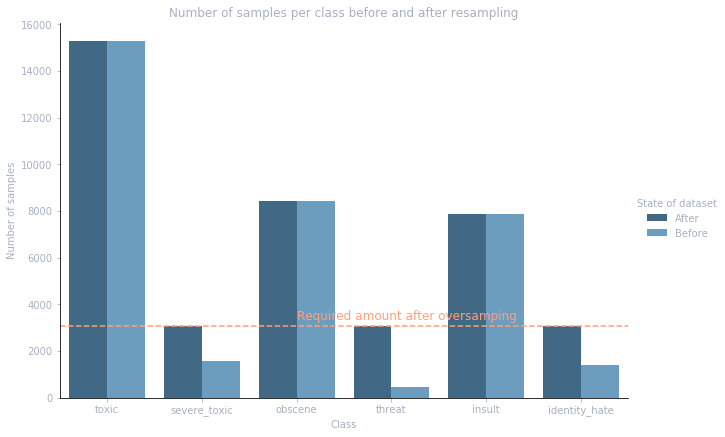

In [40]:
fg = sns.catplot(x='Class', 
            y='Number of samples', 
            hue='State of dataset', 
            data=data_for_barplot, 
            kind='bar', 
            palette="Blues_d", 
            height=6, aspect=1.5)

axes = fg.axes.flatten()

axes[0].set_title('Number of samples per class before and after resampling')
axes[0].axhline(n_samples_deficiency_factor, ls='--', color='LightSalmon')
axes[0].text(2, n_samples_deficiency_factor + 300, 
             'Required amount after oversamping', color='LightSalmon', fontsize=12)

### Prepare data for model training

#####  Custom Tokenizer

In [41]:
time_flag = tap_timer(time_flag, start=True)

num_words = 25000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(comments_train))
print('Found %d unique words.' % len(tokenizer.word_index))

time_flag = tap_timer(time_flag, start=False)

Found 210337 unique words.


In [42]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

##### Pre-trained  model

In [43]:
pretrained_models = {}

glove_params = {}
fasttext_params = {}
glove_params['file_path'] = f'{PRETRAINED_PATH}glove.6B.100d.txt'
fasttext_params['file_path'] = f'{PRETRAINED_PATH}wiki-news-300d-1M.vec'
glove_params['embedding_output_dim'] = 100
fasttext_params['embedding_output_dim'] = 300

pretrained_models['glove'] = glove_params
pretrained_models['fasttext'] = fasttext_params

In [44]:
active_model = 'fasttext'

time_flag = tap_timer(time_flag, start=True)

model_file = pretrained_models[active_model]['file_path']
embeddings_index = {}
f = open(model_file, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

time_flag = tap_timer(time_flag, start=False)

Found 999995 word vectors.


In [46]:
# Prepare embedding matrix
custom_word_index = tokenizer.word_index
embedding_output_dim = pretrained_models[active_model]['embedding_output_dim']

resultant_num_words = min(num_words, len(custom_word_index)) + 1
embedding_matrix = np.zeros((resultant_num_words, embedding_output_dim))

for word, i in custom_word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

#####  Comments tokenizing

In [47]:
comments_test = test['comment_text']

tokenized_sequences_train = tokenizer.texts_to_sequences(extended_comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

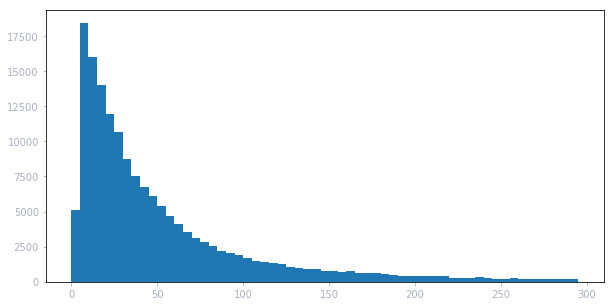

In [48]:
# Analysis of lengths of comments (maxlen param)
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

##### Vector padding

In [49]:
maxlen = 180
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=maxlen)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=maxlen)

print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('\nAfter padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

Before padding: ( 8 elements )
 [1873, 147, 6, 3476, 324, 15, 29, 141]

After padding: ( 180 elements )
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1873  147    6 3476  3

### Building the model

In [50]:
# Params for model training
batch_size = 64
epochs = 4
n_classes = len(classes_names)

##### Tuning params with Grid Search

In [51]:
# Adjust configuration of model
use_pretrained_embedding = True
use_class_weightening = False

In [52]:
def create_model(lstm_units = 100, 
                 lstm_recurrent_dropout = 0.2, 
                 lstm_return_sequences = True, 
                 dropout_rate = 0.2, 
                 relu_dense_units = 50, 
                 optimizer = 'adam'):
    model = Sequential()
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=resultant_num_words,
                            output_dim=embedding_output_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False))
    else:
        model.add(Embedding(input_dim=num_words, output_dim=embedding_output_dim))
    model.add(LSTM(units=lstm_units, 
                   return_sequences=lstm_return_sequences, 
                   recurrent_dropout=lstm_recurrent_dropout))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=relu_dense_units, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [53]:
param_grid = {
    'lstm_units': [100],
    'dropout_rate': [0.2],
    'optimizer': ['adam'],
    'relu_dense_units': [50],
    'lstm_recurrent_dropout': [0.2],
    'lstm_return_sequences': [True]
}

In [54]:
# Define callbacks
name_checkpoint_file = 'checkpoint.weights.hdf5'
checkpoint = ModelCheckpoint(filepath=f'{MODEL_PATH}{name_checkpoint_file}',
                             monitor='val_loss',
                             mode='min',
                             verbose=2,
                             save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=2)

callbacks_list = [checkpoint, early_stopping]

In [55]:
model = KerasClassifier(build_fn=create_model, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1,
                        verbose=2)

# currently not used
if use_pretrained_embedding:
    n_jobs = None
else:
    n_jobs = -1

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

### Model training

In [56]:
if use_class_weightening:
    class_weight = imbalance_ratios_class_nums
else:
    class_weight = None

In [ ]:
X_train = fixed_sequences_train
y_train = extended_labels_train

time_flag = tap_timer(time_flag, start=True)

grid_result = grid.fit(X_train, 
                       y_train, 
                       class_weight=class_weight, 
                       callbacks=callbacks_list, 
                       verbose=2)

time_flag = tap_timer(time_flag, start=False)

In [48]:
print("Best params:\n %s (score: %f)" % (grid_result.best_params_, grid_result.best_score_))

Best params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50} (score: 0.968938)


In [49]:
params = grid_result.cv_results_['params']
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
print('All results:')
for param, mean, std in zip(params, means, stds):
    print('\nSet of params:\n %r\n Mean: (%f); Standard deviation: %f' % (param, mean, std))

All results:

Set of params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50}
 Mean: (0.968938); Standard deviation: 0.019558


##### Save and load model

In [39]:
name_model_file = 'fasttext.model.json'
name_weights_file = 'fasttext.weights.h5'

def save_model_to_JSON(model):
    model_json = model.to_json()
    with open(f'{MODEL_PATH}{name_model_file}', 'w') as json_file:
        json_file.write(model_json)
    print('Saved model to disk')
        
def save_weights_to_HDF5(model):
    model.save_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Saved weights to disk')

def load_json_wih_weights_to_model(name_model_file, name_weights_file):
    json_file = open(f'{MODEL_PATH}{name_model_file}', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Loaded \'%s\' model with weights from disk' % name_model_file)
    return loaded_model

In [51]:
# Save model
best_model = grid_result.best_estimator_.model
save_model_to_JSON(best_model)
save_weights_to_HDF5(best_model)

Saved model to disk
Saved weights to disk


In [40]:
# Load model
loaded_model = load_json_wih_weights_to_model(name_model_file, name_weights_file)
loaded_model.summary()

Loaded 'fasttext.model.json' model with weights from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 180, 300)          7500300   
_________________________________________________________________
lstm_4 (LSTM)                (None, 180, 100)          160400    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 306       
Total params: 7,666,056
Trainable params: 165,756
Non-trainable params: 7,500,300
__

##### Predicting on test dataset

In [53]:
def drop_entries_with_invalid_labels(test, test_labels):
    indexes_invalid_labels = test_labels.index[test_labels['toxic'] == -1].tolist()
    valid_test_labels = test_labels.drop(test_labels.index[indexes_invalid_labels])
    valid_test = np.delete(test, indexes_invalid_labels, axis=0)
    assert (valid_test_labels.shape[0] == len(valid_test))
    return valid_test, valid_test_labels

In [54]:
test_labels_without_ids = test_labels.iloc[:,1:]
X_test, y_test_df = drop_entries_with_invalid_labels(fixed_sequences_test, test_labels_without_ids)

time_flag = tap_timer(time_flag, start=True)

y_pred_float = loaded_model.predict([X_test], batch_size=1024)
y_pred = (y_pred_float > .5)
y_test = y_test_df.values

time_flag = tap_timer(time_flag, start=False)

##### Use metrics for imbalanced learning

In [65]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action="ignore",category=UndefinedMetricWarning)

with warnings.catch_warnings():
    print('Some classes has no predicted samples!')

precision, recall, fscore, support = score(y_test, y_pred)
kappa = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
specificity = specificity_score(y_test.ravel(), y_pred.ravel())
sensitivity = sensitivity_score(y_test.ravel(), y_pred.ravel())

Some classes has no predicted samples!


In [66]:
print('Precision: \t', list(map('{:.3f}'.format, precision)))
print('Recall: \t', list(map('{:.3f}'.format, recall)))
print('F1 score: \t', list(map('{:.3f}'.format, fscore)))
print('Support: \t', support)
print('\n --- \n')
print('Kappa score: \t{:.3f}'.format(kappa))
print('Specificity: \t{:.3f}'.format(specificity))
print('Sensitivity: \t{:.3f}'.format(sensitivity))

Precision: 	 ['0.544', '0.427', '0.616', '0.000', '0.676', '0.670']
Recall: 	 ['0.865', '0.368', '0.780', '0.000', '0.634', '0.521']
F1 score: 	 ['0.668', '0.395', '0.688', '0.000', '0.654', '0.586']
Support: 	 [6090  367 3691  211 3427  712]

 --- 

Kappa score: 	0.642
Specificity: 	0.979
Sensitivity: 	0.747


Confusion matrices:


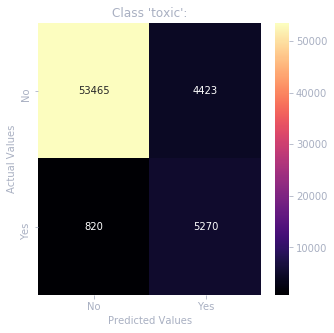

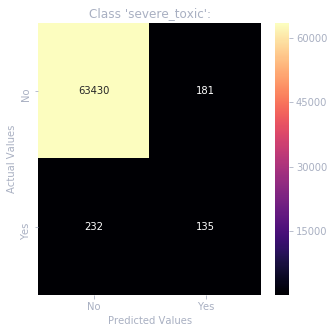

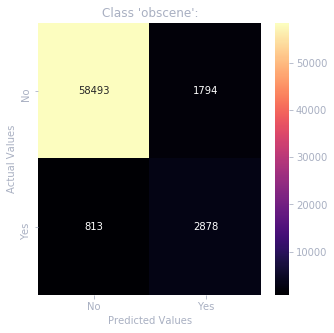

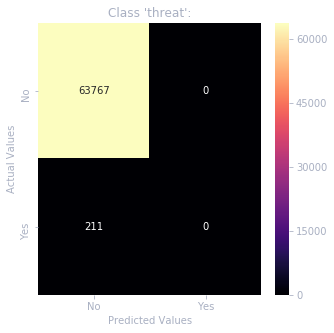

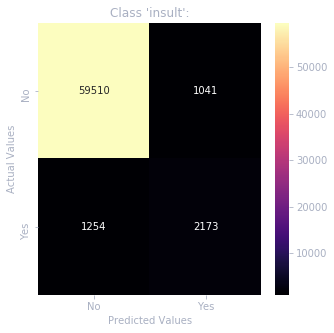

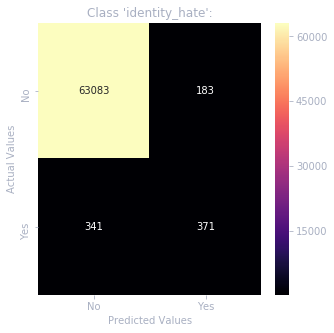

In [67]:
conf_matrices = {}
for label in range(len(classes_names)):
    y_test_label = y_test[:, label]
    y_pred_label = y_pred[:, label]
    conf_matrices[classes_names[label]] = confusion_matrix(y_pred=y_pred_label, y_true=y_test_label)
    
print("Confusion matrices:")
for label, matrix in conf_matrices.items():
    df_cm = pd.DataFrame(matrix, index = [i for i in ['No', 'Yes']], columns = [i for i in ['No', 'Yes']])
    plt.figure(figsize = (5, 5))
    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, cmap='magma', fmt='g')
    ax.set_title("Class '{}':".format(label))
    ax.set_ylabel('Actual Values')    
    ax.set_xlabel('Predicted Values')
    plt.show()

##### Create submission file

##### Manual model testing

In [68]:
def prepare_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=maxlen)

In [ ]:
single_comment = 'I will eat your ice cream'
single_prediction = loaded_model.predict([prepare_comment([single_comment])], batch_size=1024)
results = pd.DataFrame(single_prediction, columns=[classes_names])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)

##### <font color="#7affa0">TODO:</font>
- <font color="green">✔</font> add plot of spammers classification based on variable spam_ratio
- ⌛ execute SearchGrid of model's params
    - ⌛ try diffrent values of non-model params num_words (Tokenizer), maxlen (padding)
- <font color="green">✔</font> update Tensorflow to GPU version
- ⌛ try diffrent architectures:
    - ⌛ Pooling (Max -> Average)
    - <font color="green">✔</font> Early Stopping and Checkpoints (callbacks)
    - <font color="green">✔</font> Pretrained Embedding (Glove)

##### <font color="#a07aff">Konsultacje I:</font>
- Klasyfikacja dwupoziomowa: binarna (clean/toxic data) + wieloetykietowa (tylko toxic data)
- <font color="green">✔</font> Dataset jest niezrównoważony (10/90); klasyfikacja niezrównoważona
- <font color="green">✔</font> Oversampling
- <font color="green">✔</font> Sprawdzić macierz pomyłek
- <font color="green">✔</font> Klasyfikacja hierarchiczna (np. severe toxic zawsze jest toxic)
-  <font color="green">✔</font> Zrobić przegląd literatury

##### <font color="#a07aff">Konsultacje II:</font>
- <font color="green">✔</font> FastText
- sprawdzić klasyfikację hierarchiczną
- dodatkowe kolumny:
    - 'Clean' (modyfikacja imbalance_ratios_class_nums)
    - 'Unique Words Percentage' (wejście na Dense, równolegle do Poolingu)
- oversampling przy klasyfikacji One-vs.-rest (5 klasyfikatorów, oversampling binarny)
- znaleźć dodatkowe datasety z poszczególnych kategorii